<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: *Elias CHERIF*
### ***username***: *gems-ec2823*
### ***CID***: *02522867*


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Justification of choice VAE/GAN

Explain in **two or three sentences** and/or a few **bullet points** why you have chosen to use a VAE or a GAN. There is no right or wrong choice, but the justification of the choice will be assessed.

your answer here

**In the context of the project, I have decided to work with GANs :
-	Creativity and Variability: GANs are capable of producing a wide range of images, thus reflecting the diversity of the training data. This ability is particularly useful for creating new, realistic images.
-	High Visual Quality: GANs are especially renowned for their ability to generate realistic and high-resolution images. This feature is crucial when visual quality is an important aspect of the project.
-	Likelihood Maximization: Implicitly, GANs maximize likelihood by combining two networks, a generator and a discriminator, working in opposition.
-	Visually Realistic Results: GANs are recognized for producing results that are not 'sharper'. **


## Data preparation

add text blocks as you need

In [2]:
### add code blocks as you need

In [3]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 12.5 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['Generator']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from torch.utils.data import TensorDataset, DataLoader
import random

In [5]:
from google.colab import drive
drive.mount('/content/drive')  #access the images I have stored in my drive

Mounted at /content/drive


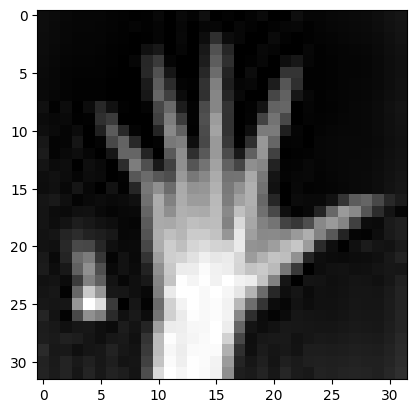

Nombre de lots = 63
Nombre d'images = 8010


In [28]:
class CustomImageDataset(Dataset): #uploading and processing images
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.images = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

path_images = '/content/drive/My Drive/real_hands'

#Transformations
transformations = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5]) #for values between -1 and 1
])

batch_size = 128
dataset = CustomImageDataset(images_dir=path_images, transform=transformations)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


images = next(iter(data_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

print('Nombre de lots = ' + str(len(data_loader)))
print('Nombre d\'images = ' + str(len(dataset)))

In [7]:
#some statistics to check our transformations
images = images.float()
min_val = images.min().item()
max_val = images.max().item()
mean_val = images.mean().item()
std_val = images.std().item()

print("min/max:", min_val, "/", max_val)
print("mean: ", mean_val)
print("std: ", std_val)

min/max: -1.0 / 1.0
mean:  -0.4513664245605469
std:  0.6162519454956055


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Network design and implementation

add text blocks as you need

In [9]:
### add code blocks as you need

In [55]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.init_size = 8 #Initial size before upscaling

        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        #Layer to start the convolution
        self.start_conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #upsampling with ConvTranspose2d
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )


        self.conv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        #output
        self.out_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  #values are between -1 and 1
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        out = self.start_conv(out)
        out = self.conv_block1(out)
        out = self.conv_block2(out)
        img = self.out_conv(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #input layer
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)

        #hidden layer 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)
        self.drop2 = nn.Dropout2d(0.1)
        self.bn2 = nn.BatchNorm2d(32)

        #hidden layer 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        self.drop3 = nn.Dropout2d(0.1)
        self.bn3 = nn.BatchNorm2d(64)

        # Hidden layer 3
        self.conv4 = nn.Conv2d(64, 128, 3, 2, 1)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace=True)
        self.drop4 = nn.Dropout2d(0.1)
        self.bn4 = nn.BatchNorm2d(128)

        #final
        self.val_layer = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.lrelu1(self.conv1(img))
        out = self.bn2(self.drop2(self.lrelu2(self.conv2(out))))
        out = self.bn3(self.drop3(self.lrelu3(self.conv3(out))))
        out = self.bn4(self.drop4(self.lrelu4(self.conv4(out))))
        out = out.view(out.shape[0], -1)
        validity = self.val_layer(out)

        return validity


G = Generator().to(device)
D = Discriminator().to(device)

This GAN architecture uses convolutional layers as they are better suited for image problems. It consists of two key components: a Generator and a Discriminator.

Generator Class :

Uses ConvTranspose2d layers to progressively increase the image resolution. Batch normalization (BatchNorm2d) and LeakyReLU activation layers are included for improved stability and performance.
Output Layer: Produces the final image using standard convolutional layers and employs Tanh to ensure pixel values are between -1 and 1.


Discriminator Class (Discriminator):


Convolutional and Dropout Layers: Uses Conv2d convolutional layers to reduce image resolution and extract features. Dropout is included to prevent overfitting.
Hidden Layers and Activation: Hidden layers with LeakyReLU activations and batch normalization process the extracted features.
Output Layer: Uses a linear layer followed by a Sigmoid activation to produce a probability indicating whether the image is real or generated.


In [58]:
G

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (start_conv): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_block1): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_block2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (out_conv): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyR

In [59]:
D

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (drop2): Dropout2d(p=0.1, inplace=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (drop3): Dropout2d(p=0.1, inplace=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lrelu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (drop4): Dropout2d(p=0.1, inplace=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (val_layer): Sequential(
    (0): Linear(in_features=5

In [11]:
# define loss
criterion = nn.BCELoss()
z_dim = 100
bs = 128  # batch_size

lr = 0.0001

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

## Training and evaluation loops

add text blocks as you need

In [12]:
### add code blocks as you need

Training Loop for D

In [13]:
def D_train(x):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    current_bs = x.size(0) #taking into account differences in size
    x_real, y_real = x.view(-1,1, 32,32), torch.ones(current_bs, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(current_bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(current_bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

Training Loop for G

In [14]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()
    current_bs = x.size(0) #taking into account differences in size
    # sample vector and produce generator output
    z = torch.randn(current_bs, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator

    y = torch.ones(current_bs, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

add text blocks as you need

In [15]:
### add code blocks as you need

In [60]:
# define loss
criterion = nn.BCELoss()
z_dim = 100
bs = 128  # batch_size

lr = 0.0001

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

The binary cross entropy loss function (BCELoss) is commonly used in GANs as it measures the discriminator's efficiency in correctly classifying real and generated images.
A latent dimension of 100 is a standard choice in many GAN models. It offers a good balance between the ability to capture sufficient variability in the training data and the complexity of the model.
A learning rate of 0.0001 is often chosen for GANs because it is small enough to allow stable learning and avoid too large jumps in the parameter space, which could lead to unstable learning or non-convergence. A well-chosen learning rate is crucial, as GANs are particularly sensitive to this parameter

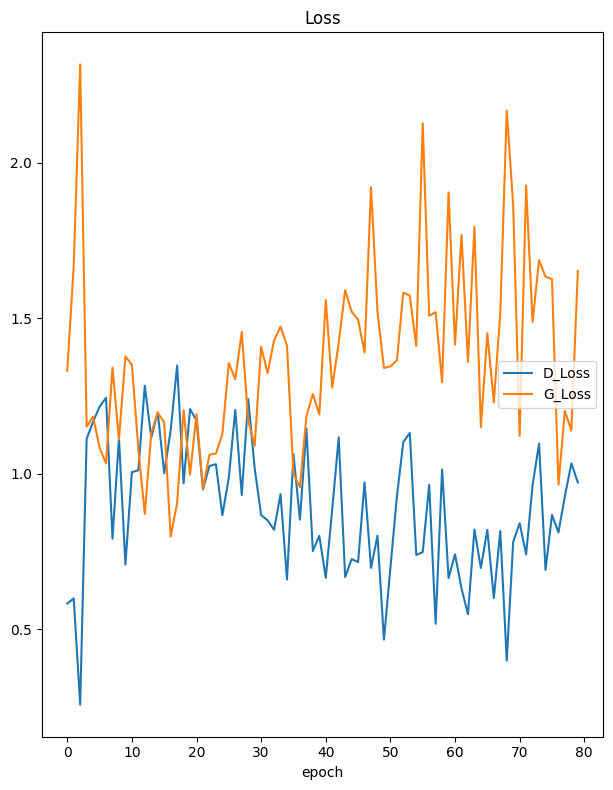

Loss
	D_Loss           	 (min:    0.257, max:    1.348, cur:    0.972)
	G_Loss           	 (min:    0.798, max:    2.317, cur:    1.652)


In [16]:
n_epoch = 80
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, x in enumerate(data_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

This code train a GAN for 80 epochs, recording and displaying discriminator (D_Loss) and generator (G_Loss) losses at each epoch. It uses PlotLosses to visualise losses during training, and saves the state of the generator (G) every 20 cycles to allow training to be resumed or the trained model to be used at a later date.

Both losses fluctuate, which is typical in the training of GANs as the generator and the discriminator are in constant competition. Towards the latter epochs, although there are still fluctuations, the loss lines appear to converge, indicating that both the generator and the discriminator are improving and that the balance between the two has stabilized. The losses of the discriminator and the generator are relatively close to each other towards the end of the training, suggesting that neither the discriminator nor the generator has consistently dominated the other. This is often considered a sign that the GAN is learning effectively.

Text(0.5, 1.0, 'Epoch = 080')

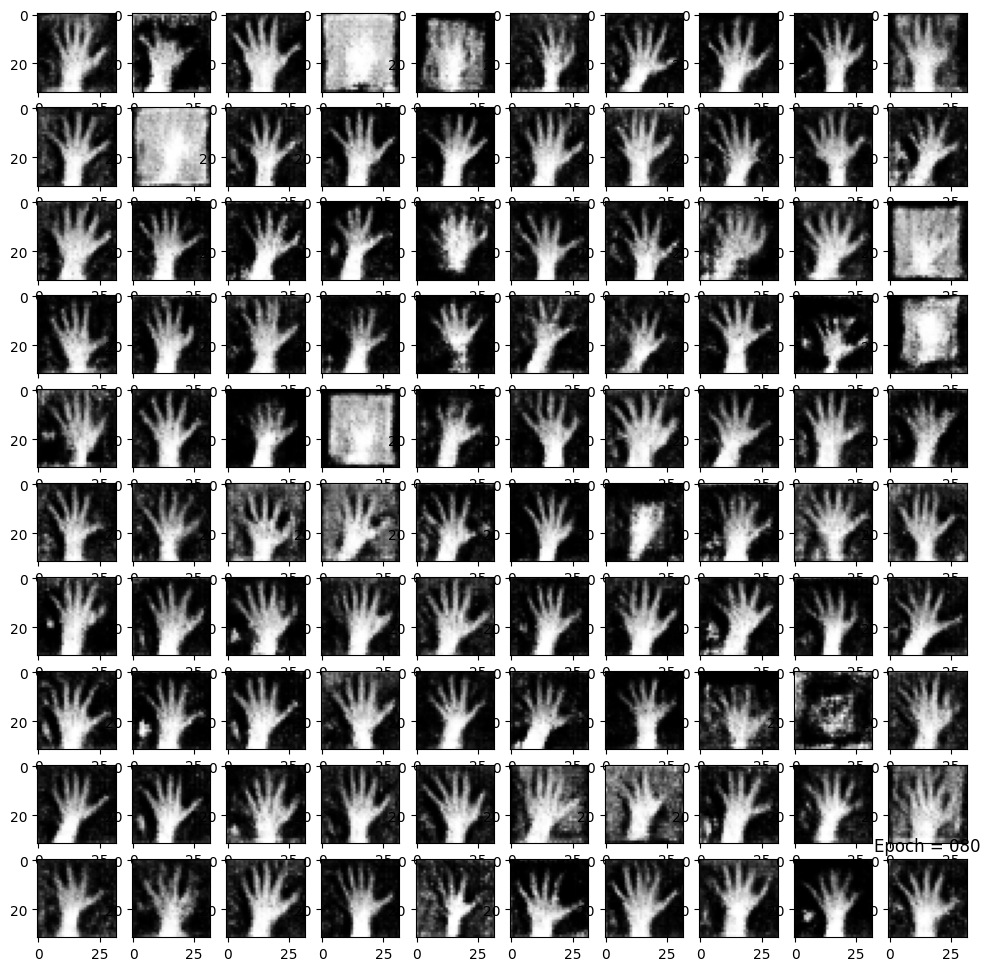

In [17]:
set_seed(1)

epoch = 80
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)

fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

The quality of the generated images is suitable; the hands are clearly recognizable.

## Generate 300 new samples with your trained network

add text blocks as you need

In [18]:
### add code blocks as you need

In [22]:
from torchvision.utils import save_image
import os

folder_path = '/content/drive/My Drive/Generated_Images'
os.makedirs(folder_path, exist_ok=True)

epoch = 80
latent_dim = 100
bs = 1

G = Generator(latent_dim)
G.load_state_dict(torch.load(f"./Generator_{epoch:03d}.pth")) #use our trained model
G.eval()

#Generate and save images
num_images = 300
for i in range(num_images):
    z = torch.randn(bs, latent_dim)
    with torch.no_grad():
        generated_image = G(z)
        #normalized_image = (generated_image + 1) / 2
        #final_image = normalized_image * 255

    #save
    save_image(generated_image, os.path.join(folder_path, f'gems-ec2823_{i+1:03d}.jpeg'))


## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

The images were saved in the previous section.